In [2]:
from tqdm import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt

import vae
import data

# Use LaTeX-style formatting
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12
})

plt.rcParams["figure.dpi"] = 300  # High resolution

plt.rcParams["font.family"] = "serif"  # Use serif font
plt.rcParams["axes.linewidth"] = 1.5  # Thicker axis lines
plt.rcParams["xtick.direction"] = "in"  # Ticks inside the plot
plt.rcParams["ytick.direction"] = "in"

In [33]:
# Creates shape random shape data.
shape_data = data.Generator(resolution=200,num_shapes=1000).generate_shapes()

# Creates PyTorch dataset.
dataset = vae.ShapeData(shape_data)

# Build VAE Model.
model = vae.VAE(200*2,5)

# Initialises model trainer.
trainer = vae.Trainer(dataset,model,lr=1e-3,batch_size=128,loss='mse')
trainer.train_model(1000)

100%|██████████| 1000/1000 [00:00<00:00, 10344.99it/s]


Epoch 1, Loss: 2181.454189300537
Epoch 2, Loss: 1504.6444606781006
Epoch 3, Loss: 1171.561170578003
Epoch 4, Loss: 1244.9351558685303
Epoch 5, Loss: 1158.8750381469727
Epoch 6, Loss: 988.9423885345459
Epoch 7, Loss: 799.2891745567322
Epoch 8, Loss: 839.2732996940613
Epoch 9, Loss: 703.1068496704102
Epoch 10, Loss: 844.7523393630981
Epoch 11, Loss: 826.3815565109253
Epoch 12, Loss: 777.0837502479553
Epoch 13, Loss: 694.9538464546204
Epoch 14, Loss: 876.1024250984192
Epoch 15, Loss: 651.1937117576599
Epoch 16, Loss: 773.1912422180176
Epoch 17, Loss: 826.4114880561829
Epoch 18, Loss: 631.1988024711609
Epoch 19, Loss: 527.0317697525024
Epoch 20, Loss: 595.477931022644
Epoch 21, Loss: 521.0233674049377
Epoch 22, Loss: 432.0536079406738
Epoch 23, Loss: 493.2951192855835
Epoch 24, Loss: 599.8801746368408
Epoch 25, Loss: 535.6082420349121
Epoch 26, Loss: 472.41724920272827
Epoch 27, Loss: 626.0557594299316
Epoch 28, Loss: 372.64621210098267
Epoch 29, Loss: 501.08287715911865
Epoch 30, Loss: 49

In [38]:
test_shapes = data.Generator(resolution=200,num_shapes=5).generate_shapes()

dt = [torch.tensor(shape.points, dtype=torch.float32).view(-1) for shape in test_shapes]

100%|██████████| 5/5 [00:00<00:00, 2047.40it/s]


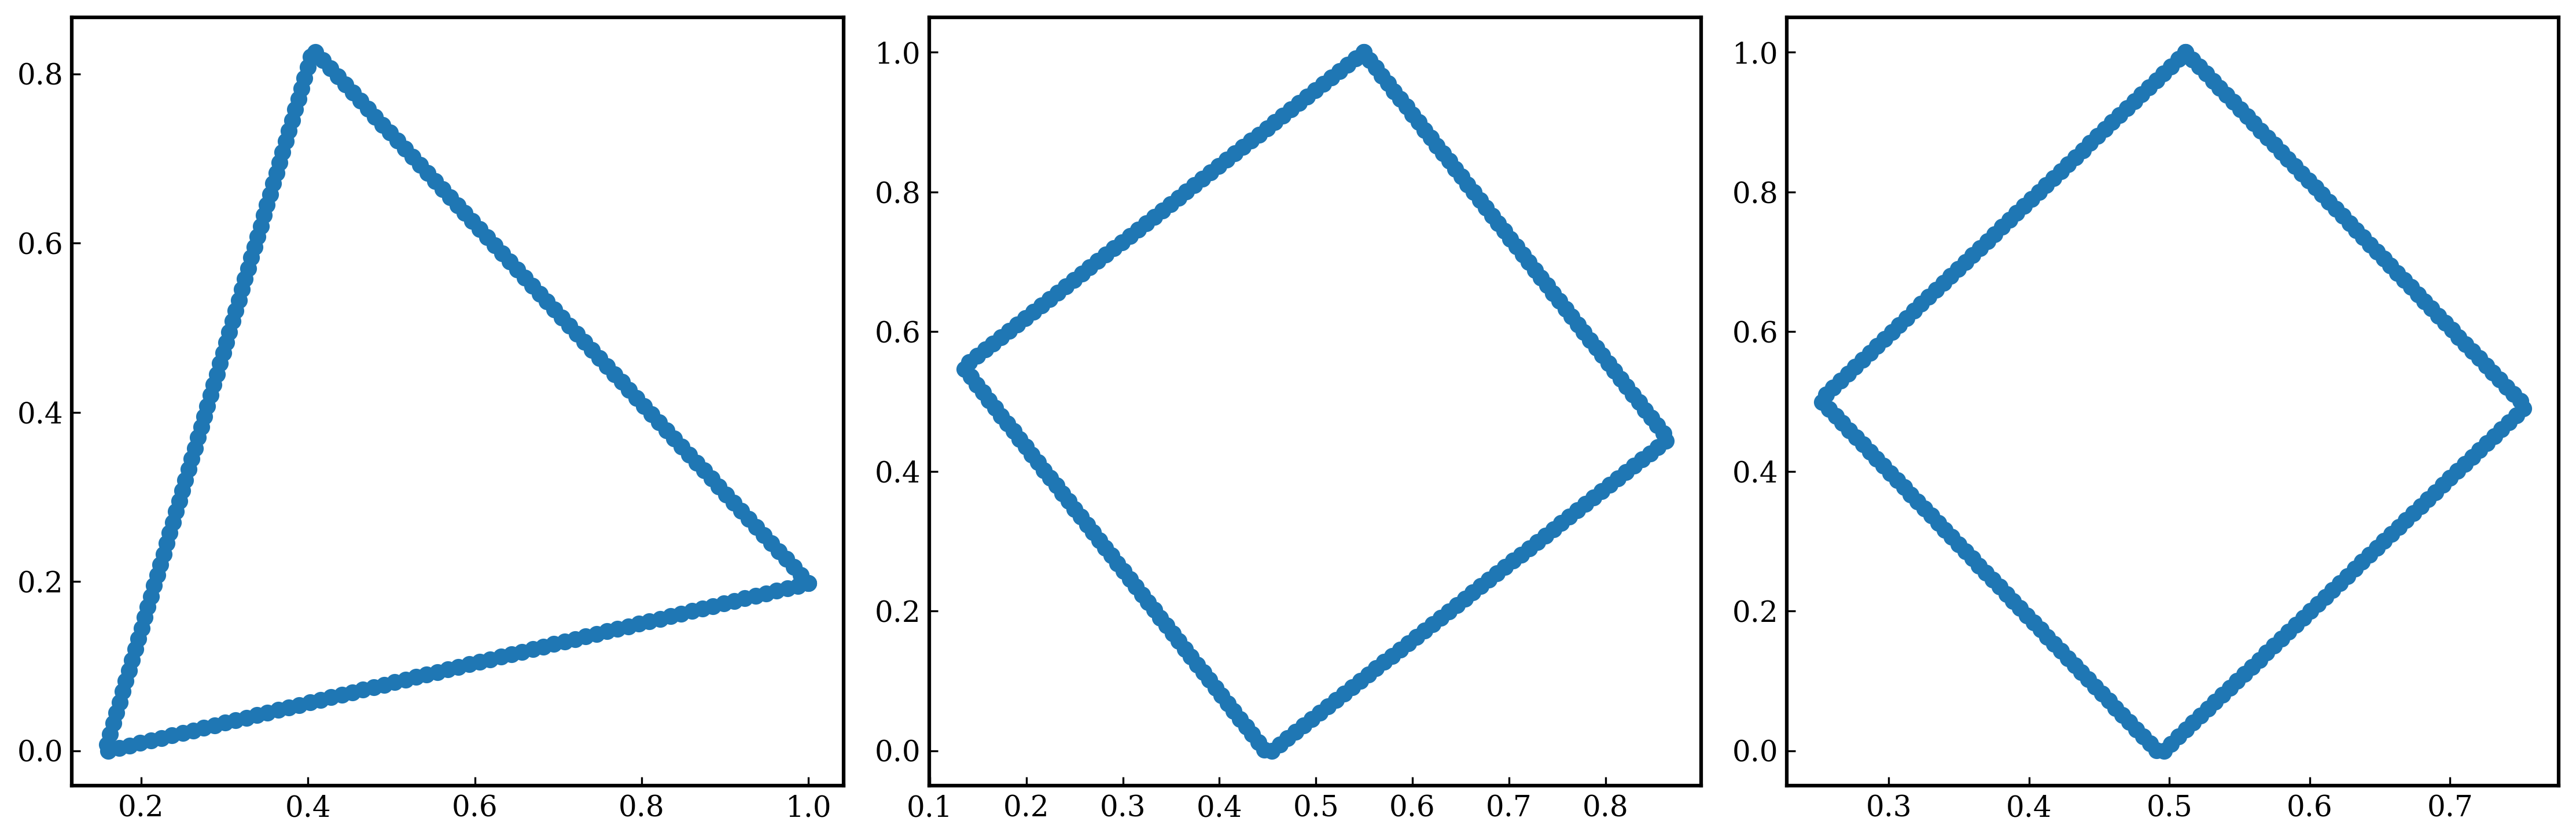

In [39]:
# Plot 3 random shapes side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle('Random Shape Examples', fontsize=14)

# Get 3 random indices
random_indices = np.random.choice(len(dt), size=3, replace=False)

for idx, ax in enumerate(axes):
    # Get random shape and reshape to 2D coordinates
    shape = dt[random_indices[idx]]  # This should give us a tensor of shape (1,400)
    
    orig_shape = shape.squeeze(0).numpy().reshape(-1,2)
    ax.plot(orig_shape[:, 0], orig_shape[:, 1], 'o-', label="Original")
    

    
plt.tight_layout()
plt.show()

In [40]:
x = model.encoder(dt[0])  # Encoder block.
mu,logvar = model.fc_mu(x),model.fc_logvar(x)  # Mu & Logvar for latent layer.
z = model.reparameterise(mu,logvar)  # Obtain latent variables.
print(z)  # Z is differet each time due to the random sampling of epsilon.

tensor([ 0.1476, -1.5366, -1.4460,  1.6363, -0.6707], grad_fn=<AddBackward0>)


(200, 2)


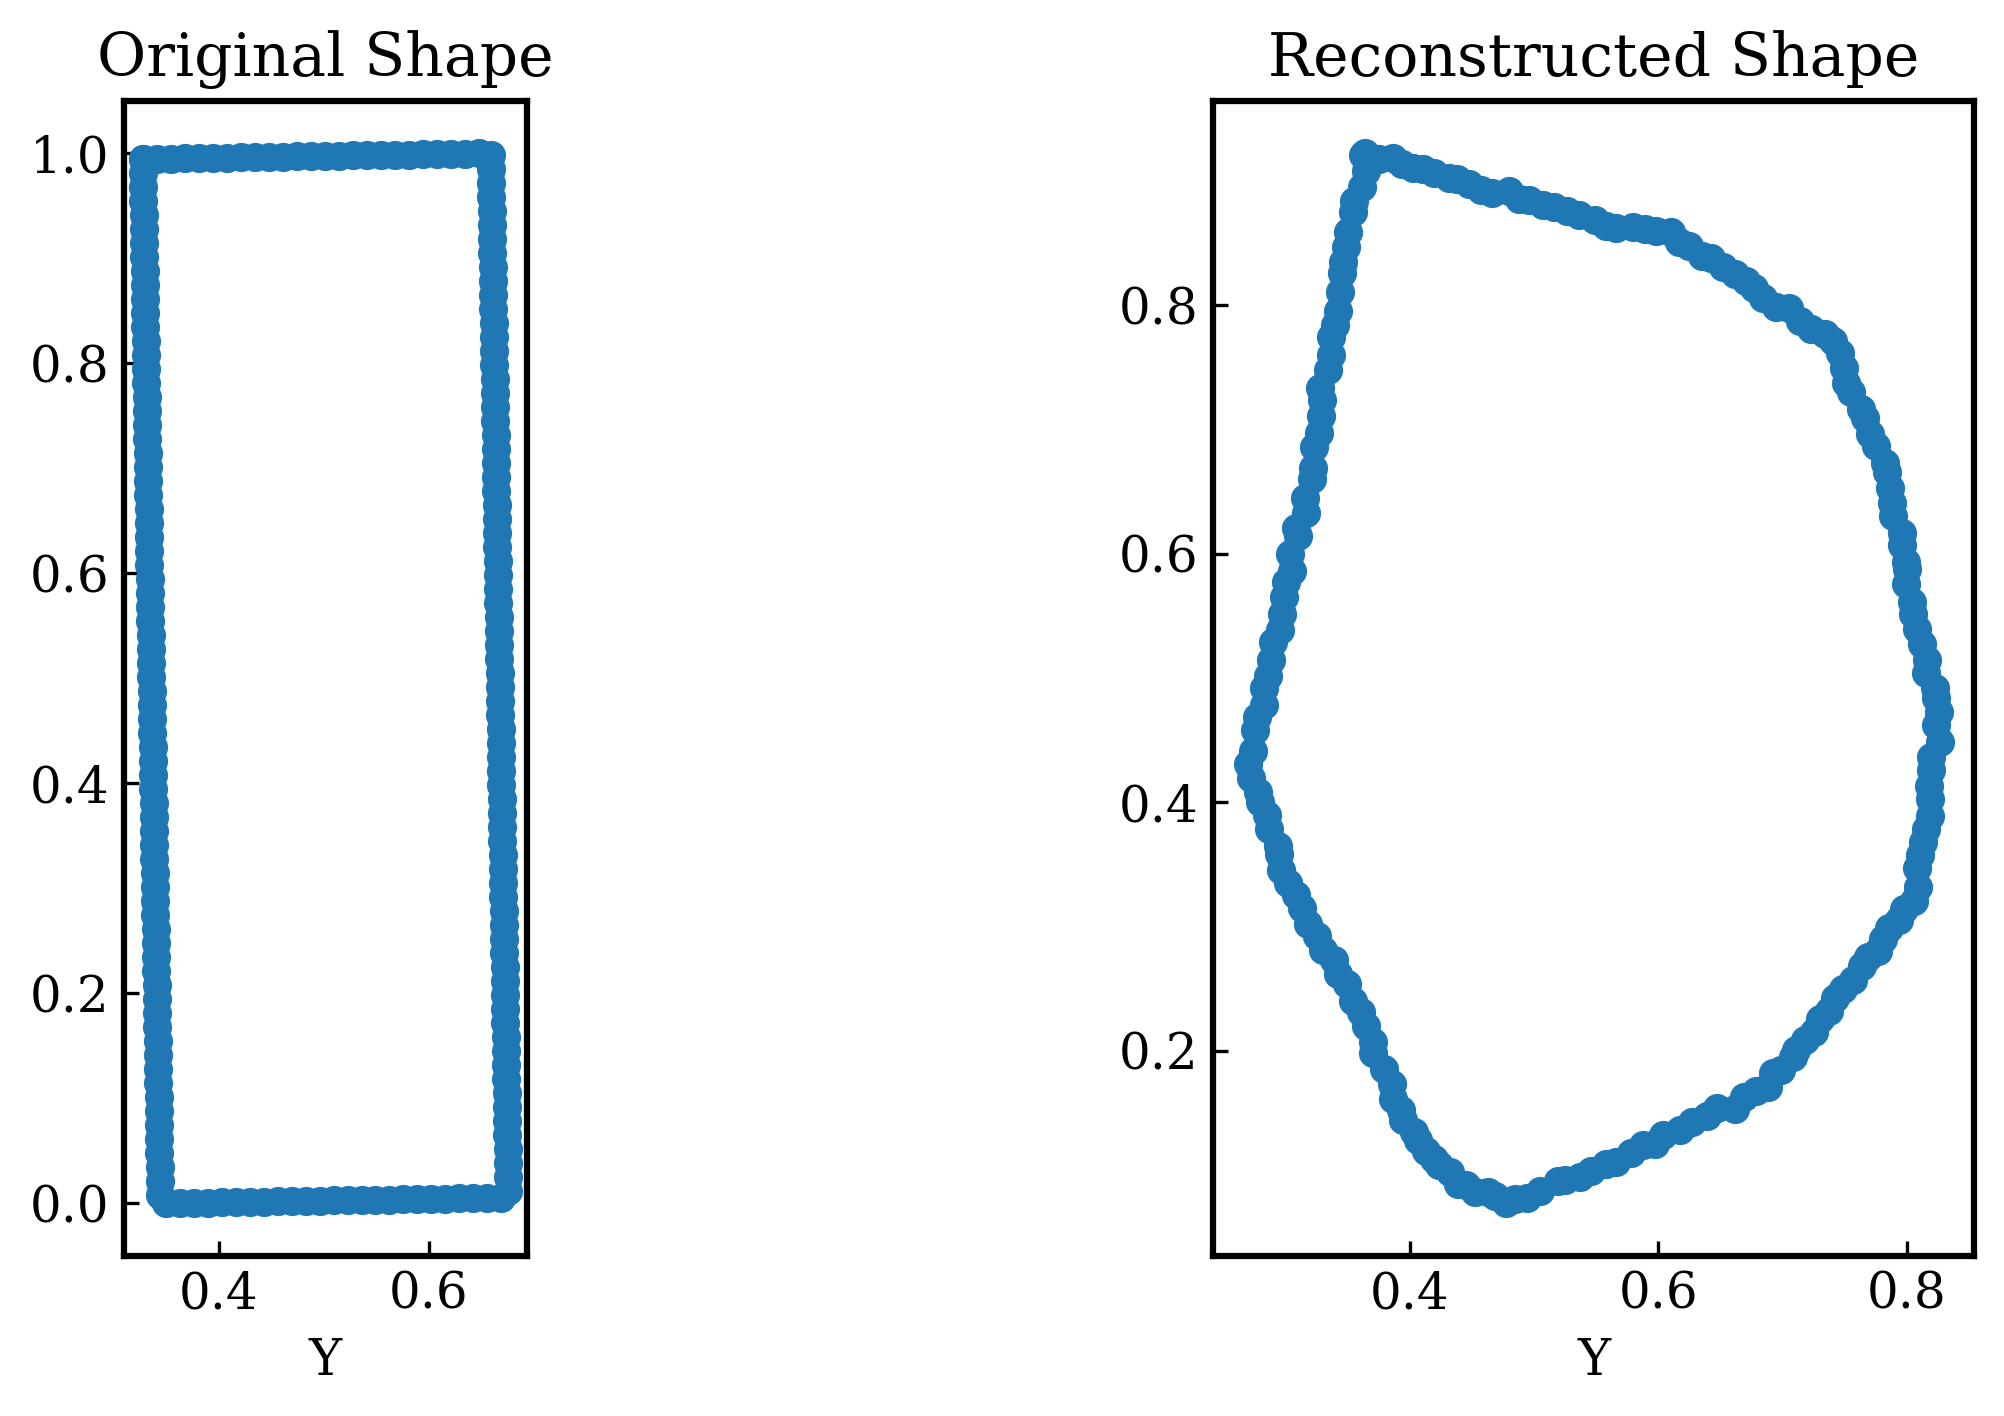

(200, 2)


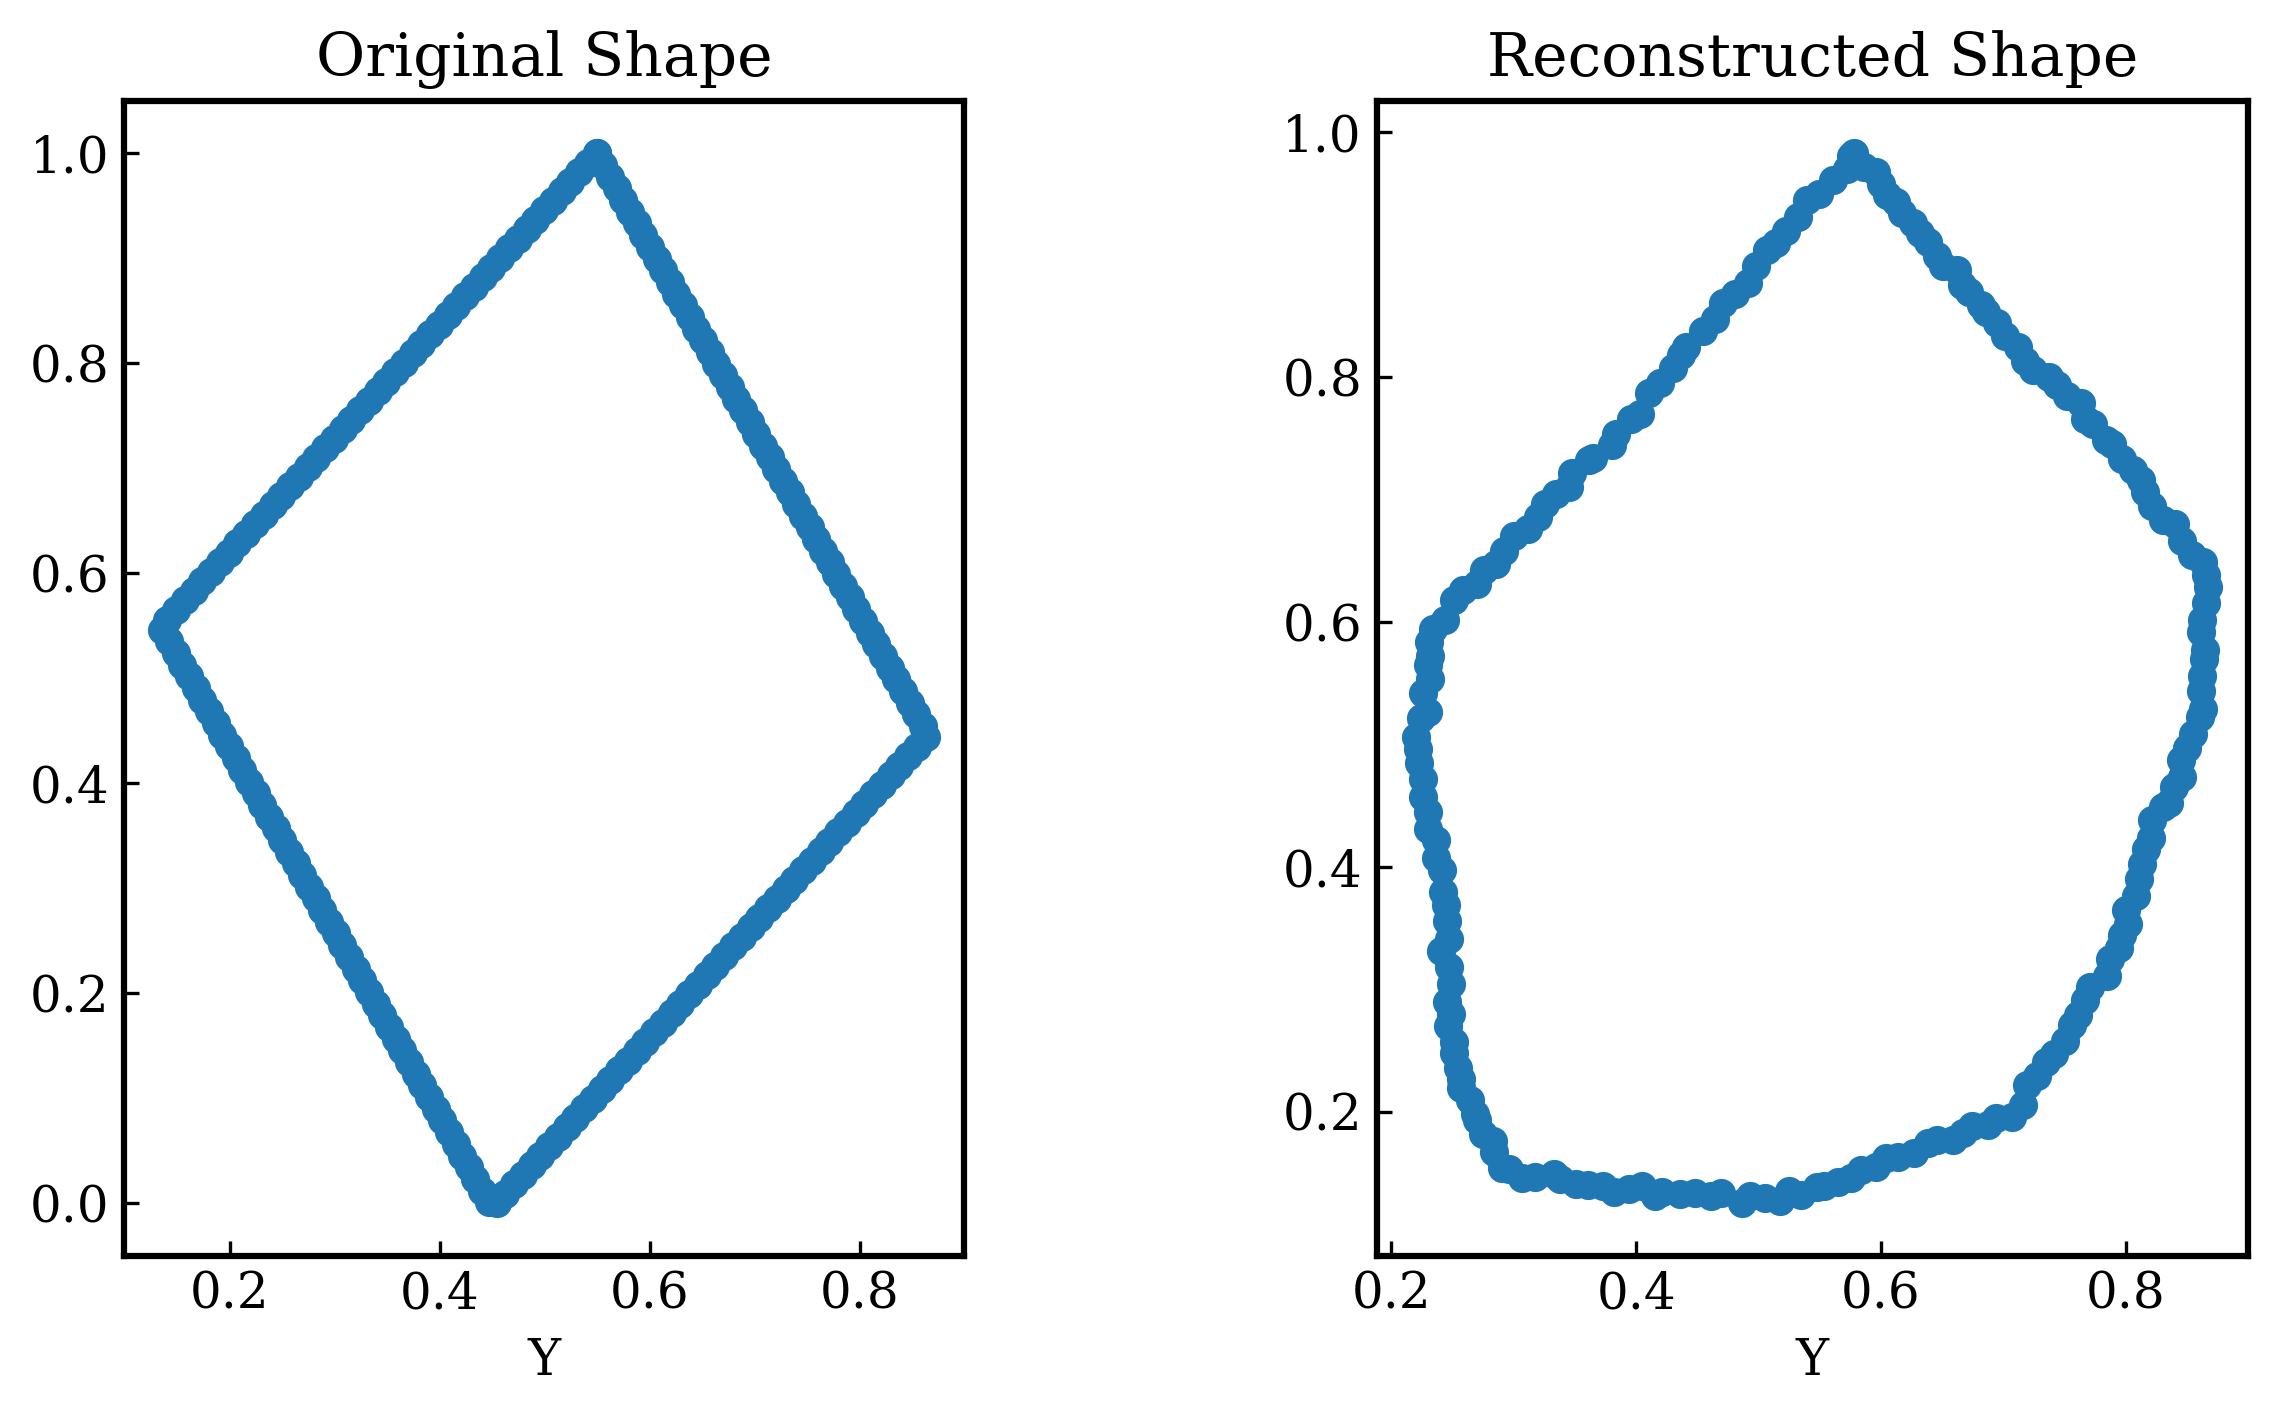

(200, 2)


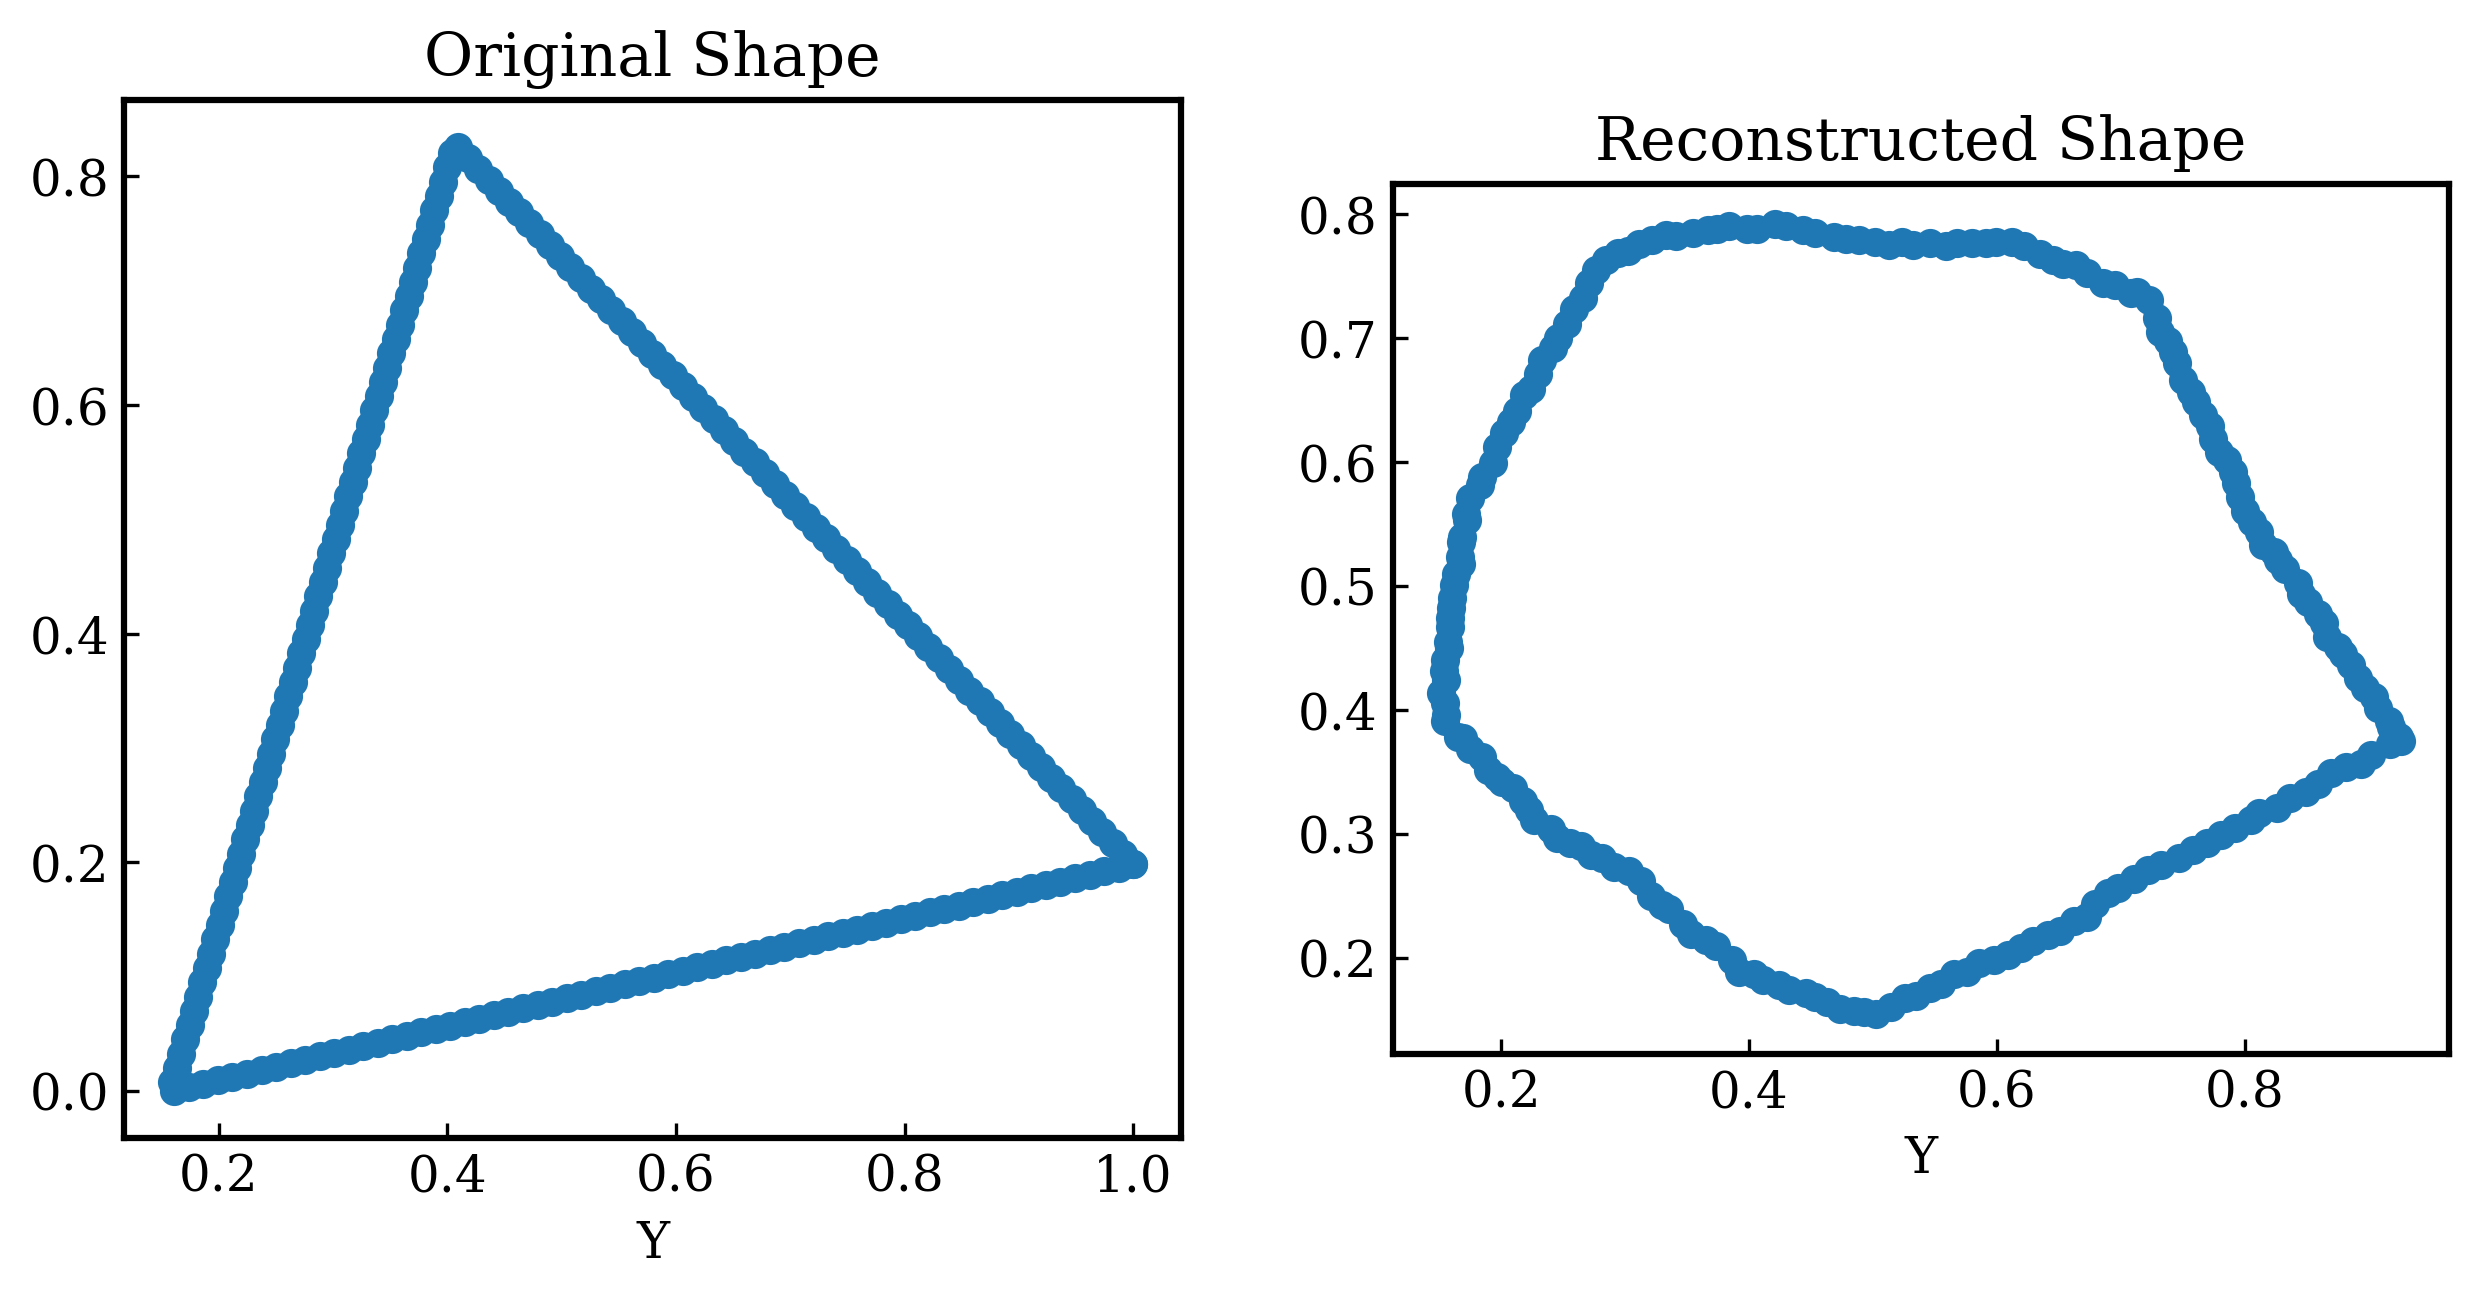

(200, 2)


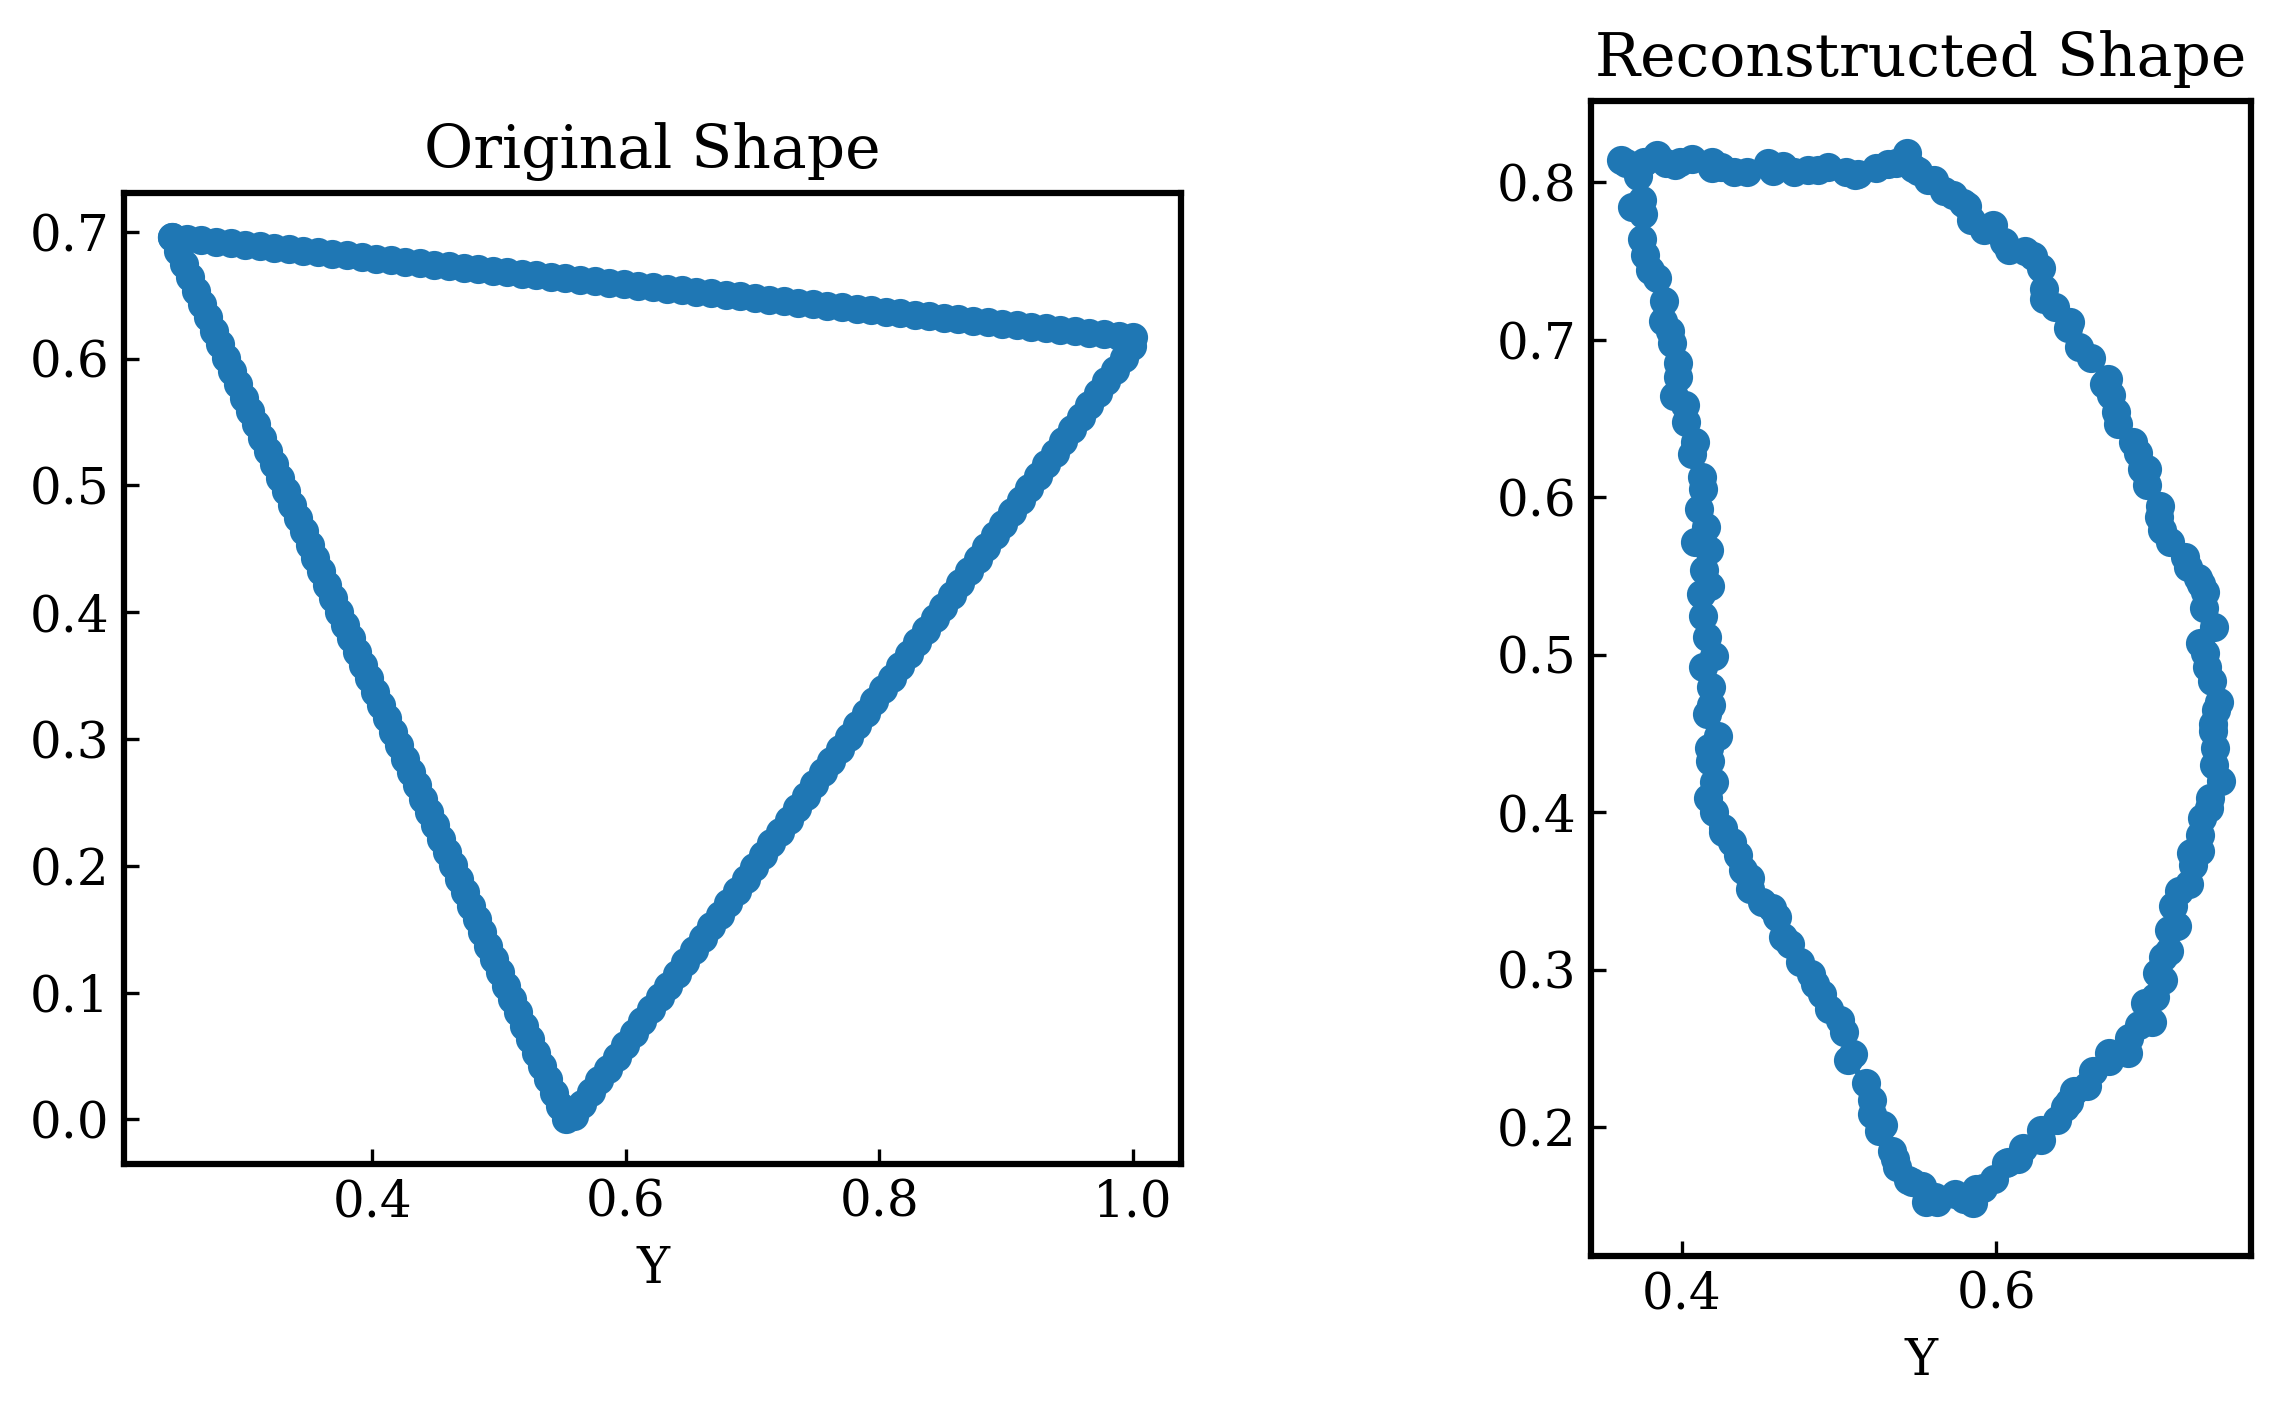

(200, 2)


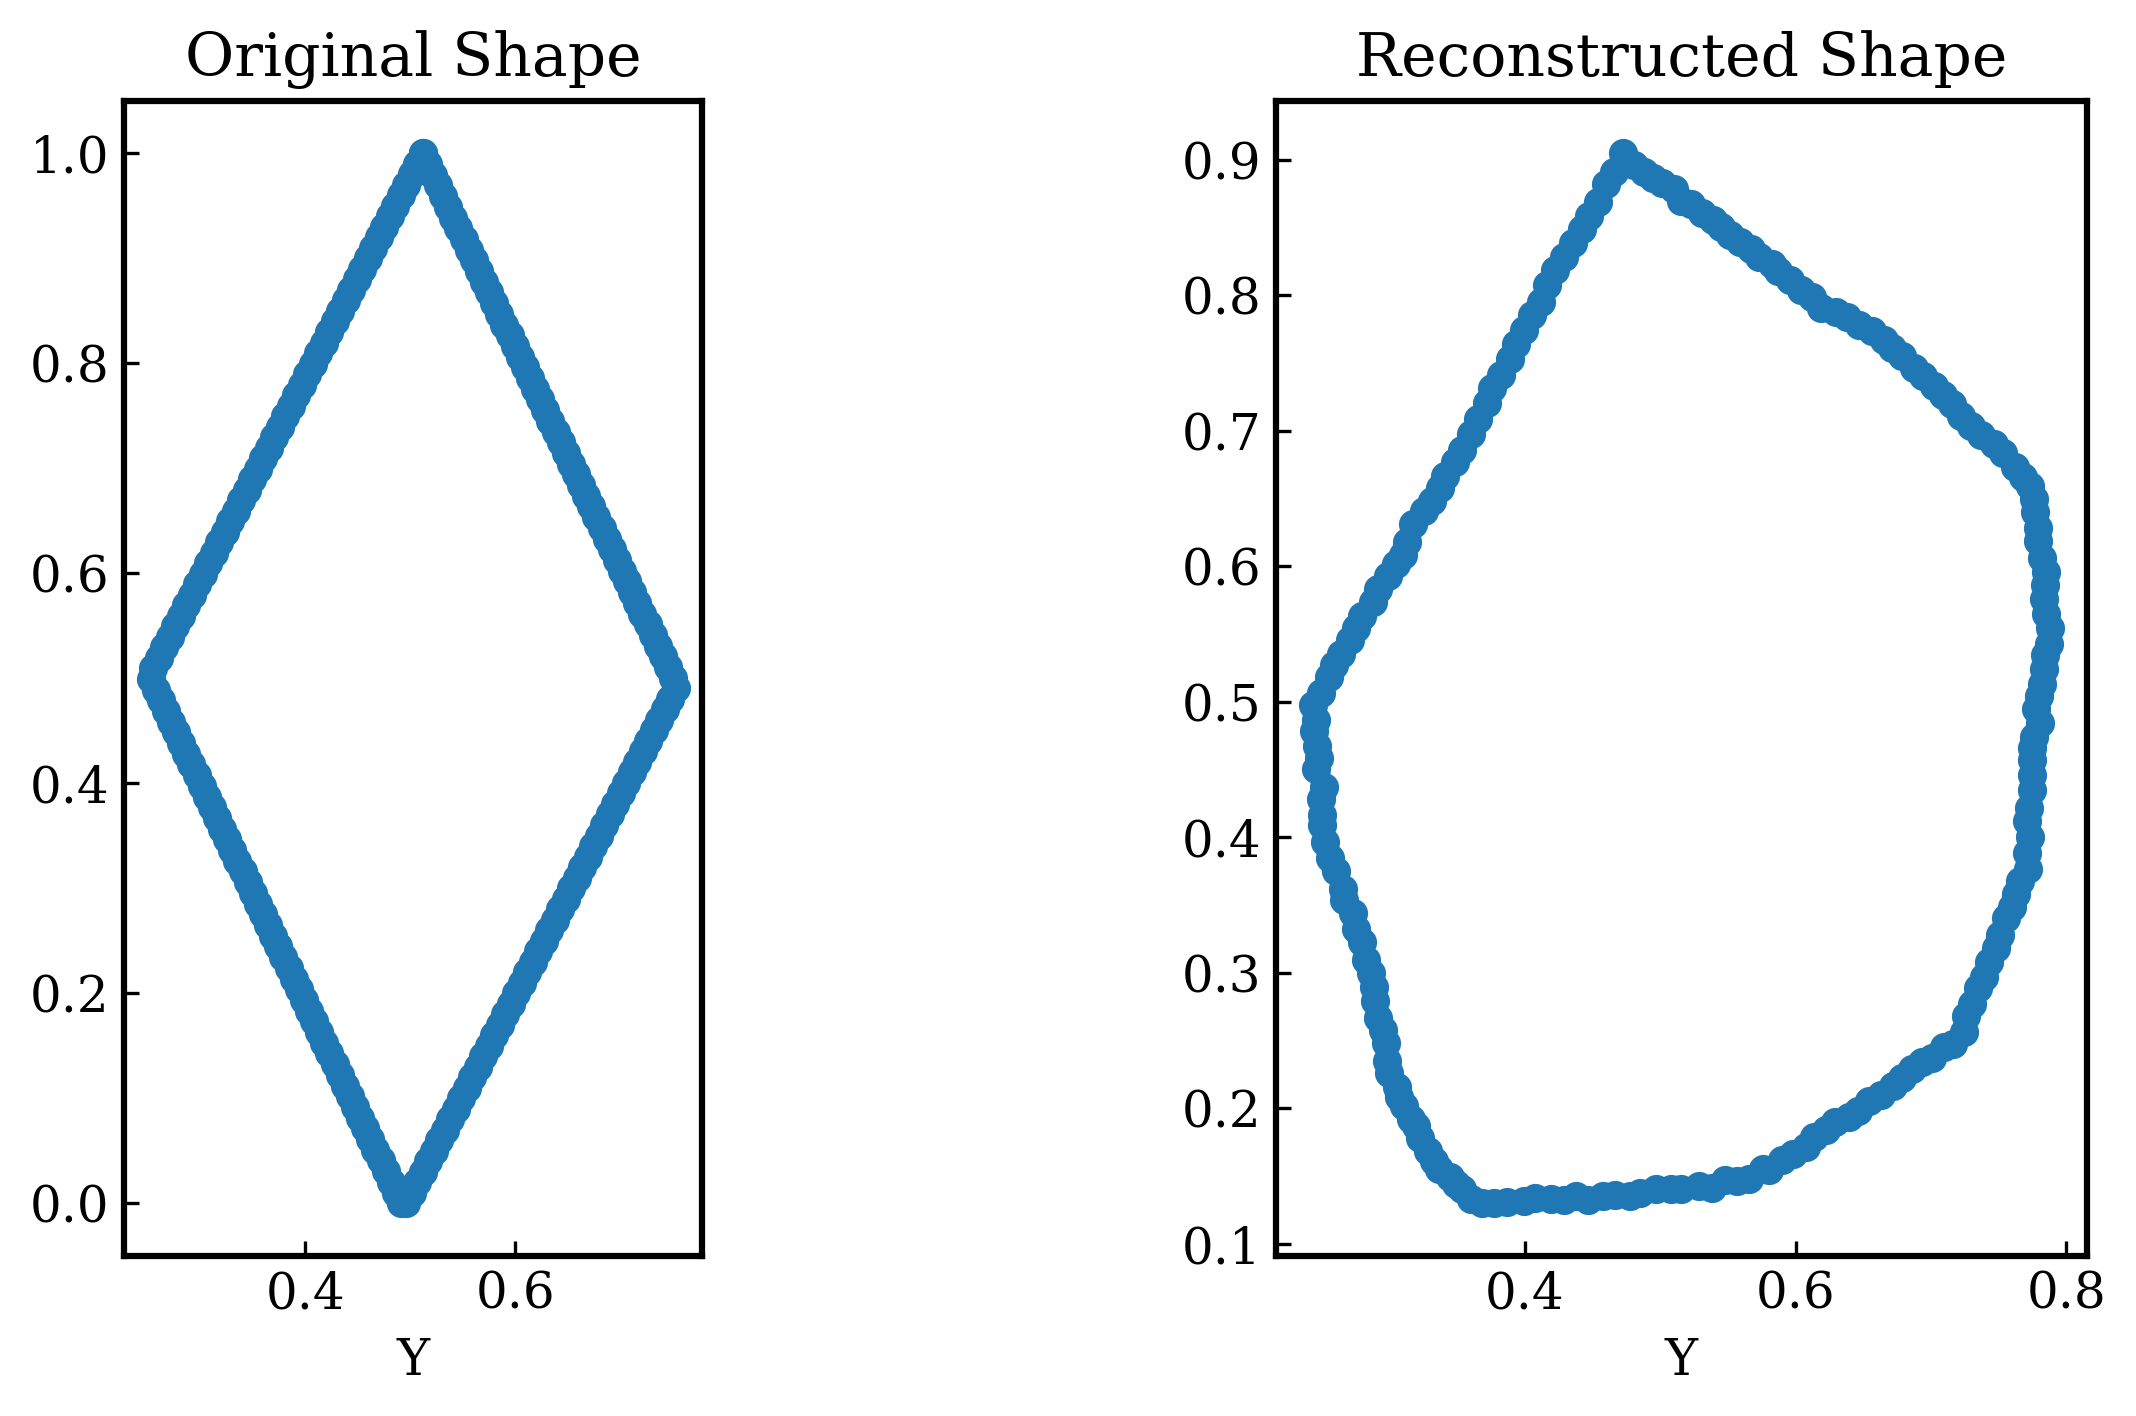

In [41]:
model.eval()

# Pass through VAE
with torch.no_grad():
    for shape in dt:
        recon_shape, mu, log_var = model(shape)
        recon_shape = recon_shape.squeeze(0).numpy().reshape(-1,2)

        orig_shape = shape.squeeze(0).numpy().reshape(-1,2)
        print(orig_shape.shape)
        # Plot Original vs. Reconstructed
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(orig_shape[:, 0], orig_shape[:, 1], 'o-', label="Original")
        axs[0].set_title("Original Shape")
        axs[0].set_xlabel('X')
        axs[0].set_xlabel('Y')
        axs[0].set_aspect('equal')

        axs[1].plot(recon_shape[:, 0], recon_shape[:, 1], 'o-', label="Reconstructed")
        axs[1].set_title("Reconstructed Shape")
        axs[1].set_xlabel('X')
        axs[1].set_xlabel('Y')
        axs[1].set_aspect('equal')

        plt.show()
